In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import math
from sklearn import preprocessing
from keras.utils import to_categorical
from keras.utils import Sequence
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain, AddGaussianSNR
from sklearn.model_selection import train_test_split
import random
import librosa
from imblearn.over_sampling import RandomOverSampler
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import BatchNormalization, MaxPool1D
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
plt.style.use('dark_background')
from sklearn.metrics import classification_report
import pandas as pd
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
def check_gpu():
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print("NO GPU")
    print('Found GPU at: {}'.format(device_name))

In [3]:
def load_data(dir='SmallCylinder/'):
    dataX = []
    dataY = []
    sr = 8000
    target = 2400  # 0.3s
    for p in os.listdir(dir):
        path = dir + p
        if path.endswith(".wav"):
            # print('Currently working on ' + p)
            row = p.split('_')
            row[1] = row[1][1]
            sp_gender = row[0] + '_' + row[1]
            x, sr = librosa.load(path, sr=sr)
            for i in range(0, len(x), int(target / 2)):  #overlap .15s
                shift = np.random.randint(60)
                y = x[i + shift : i + target + shift]
                if (len(y) == target):
                    dataY.append(sp_gender)
                    dataX.append(y)
    return dataX, dataY

In [4]:
def encode_data(dataY):
    le = preprocessing.LabelEncoder()
    Y = le.fit_transform(dataY)
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    return Y, le_name_mapping

In [5]:
def split_train_test_val(dataX, Y):    
    X_train, X_test_val, y_train, y_test_val= train_test_split(dataX, Y, test_size=0.2, random_state=42, shuffle=True, stratify=Y)
    X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42, shuffle=True, stratify=y_test_val)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
def balance_train(X_train, y_train):
    sm = RandomOverSampler(sampling_strategy='all', random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

In [7]:
def reshape_data(X_train, X_val, X_test, y_train, y_val, y_test):
    X_train = tf.convert_to_tensor(X_train)
    X_test = tf.convert_to_tensor(X_test)
    X_val = tf.convert_to_tensor(X_val)
    y_train = tf.convert_to_tensor(y_train)
    y_test = tf.convert_to_tensor(y_test)
    y_val = tf.convert_to_tensor(y_val)
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)
    X_train = tf.reshape(X_train ,(X_train.shape[0], X_train.shape[1], -1))
    X_test = tf.reshape(X_test ,(X_test.shape[0], X_test.shape[1], -1))
    X_val = tf.reshape(X_val ,(X_val.shape[0], X_val.shape[1], -1))
    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5, rollover=False),
    Gain(min_gain_in_db=-18, max_gain_in_db=24, p=0.5)
])
    
class augmented_sequence(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.reshape(batch_x, (batch_x.shape[0], batch_x.shape[1]))
        augmented_samples = augment(samples=batch_x, sample_rate=8000)
        return tf.reshape(augmented_samples, (augmented_samples.shape[0], augmented_samples.shape[1], -1)), batch_y

In [9]:
def train_model(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    for _ in range(1):
        tf.keras.backend.clear_session()
        verbose, epochs, batch_size = 1, 2000, batch_size
        gen_test = augmented_sequence(X_train, y_train, batch_size)
        n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
        with tf.device('/device:gpu:0'):
            model = Sequential(
                [
                    Conv1D(filters=64, kernel_size=600, strides=4, activation='relu', input_shape=(n_timesteps,n_features)),
                    MaxPool1D(pool_size=4),
                    Conv1D(filters=64, kernel_size=100, strides=1, activation='relu'),
                    MaxPool1D(pool_size=3),
                    Flatten(),
                    Dropout(rate=0.5),
                    Dense(256, activation='relu'),
                    Dense(128, activation='relu'),
                    Dense(n_outputs, activation='softmax')
                ]
        )
            opt = Adam(lr=0.0001)
            model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 
            reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=30, verbose=1)
            es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1)
            model.summary()
            history = model.fit(gen_test, epochs=epochs, verbose=verbose, validation_data=(X_val, y_val), callbacks=[reduce_lr, es])
        return model, history

In [12]:
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(16,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=list(dict.values(labels)))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm_perc, index=list(dict.keys(labels)), columns=list(dict.keys(labels)))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    if filename != '':
        plt.savefig(filename)

In [13]:
def plot_cm(model, X_test, y_test, filename, label_dict):
    prediction = np.argmax(model.predict(X_test), axis = 1)
    cm_analysis(np.argmax(y_test, axis = 1), prediction, filename, labels=label_dict)

In [36]:
def get_report(model, X_test, y_test):
    prediction = np.argmax(model.predict(X_test), axis = 1)
    print(classification_report(np.argmax(y_test, axis = 1), prediction))
    df = pd.DataFrame(classification_report(np.argmax(y_test, axis = 1), prediction, output_dict=True))
    inv_label_dict = { str(value) : key for (key, value) in label_dict.items() }
    df.rename(columns=inv_label_dict, inplace=True)
    return df.transpose()

In [15]:
check_gpu()

Found GPU at: /device:GPU:0


In [17]:
dataX, dataY = load_data('SmallCylinder_big/')

In [18]:
Y, label_dict = encode_data(dataY)

In [19]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_val(dataX, Y)

In [20]:
X_train, y_train = balance_train(X_train, y_train)

In [21]:
X_train, X_val, X_test, y_train, y_val, y_test = reshape_data(X_train, X_val, X_test, y_train, y_val, y_test)

In [ ]:
model, history = train_model(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32)

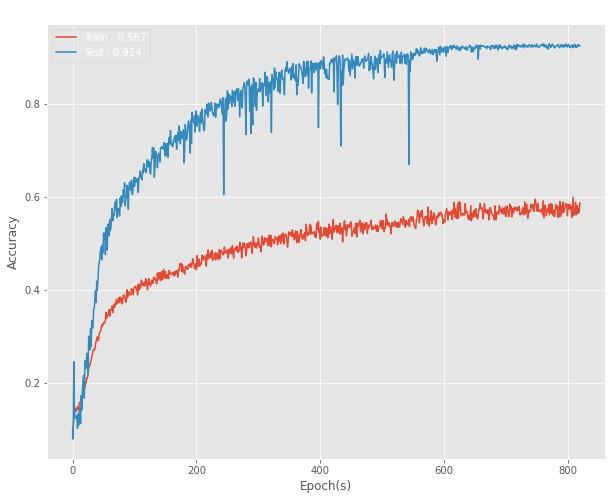

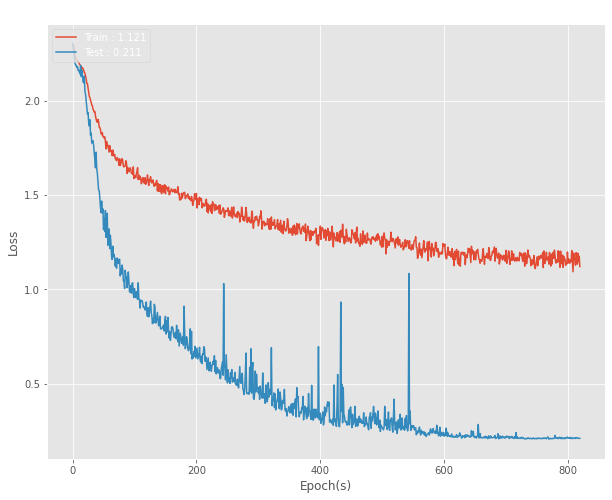

In [26]:
import seaborn as sns
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,8))
palette = sns.color_palette("mako_r", 6)
sns.lineplot(data=history.history['accuracy'])
sns.lineplot(data=history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch(s)')
plt.legend(['Train : '+str(history.history['accuracy'][-1])[:5], 'Test : '+str(history.history['val_accuracy'][-1])[:5]], loc='upper left')
plt.savefig('SmallCylinder/report/model_big_drop5_latest_acc.png')
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch(s)')
plt.legend(['Train : '+str(history.history['loss'][-1])[:5], 'Test : '+str(history.history['val_loss'][-1])[:5]], loc='upper left')
plt.savefig('SmallCylinder/report/model_big_drop5_latest_loss.png')

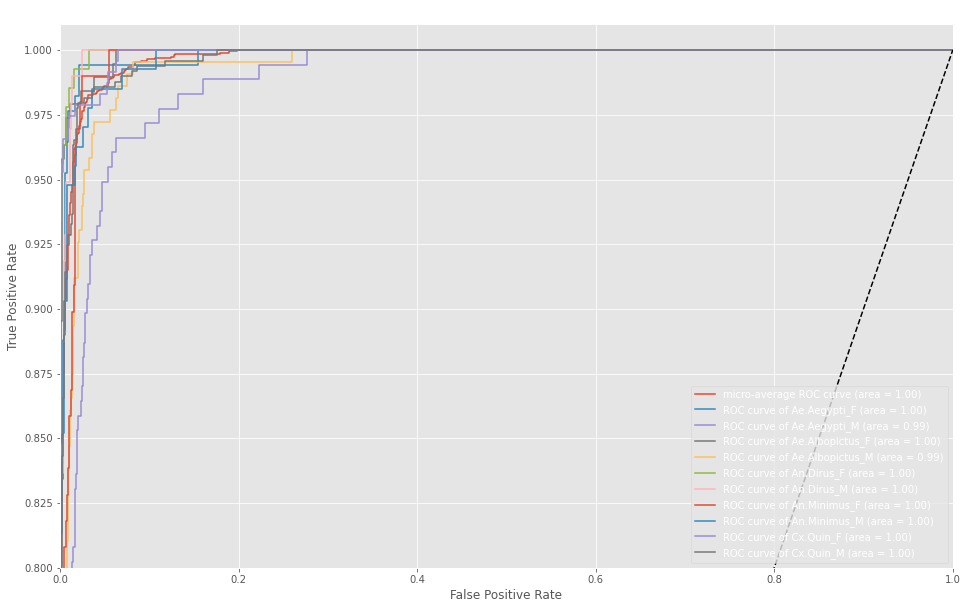

In [27]:
from sklearn.metrics import roc_auc_score,  roc_curve, auc
y_pred = model.predict(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(16,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label='ROC curve of {0} (area = {1:0.2f})'
                                   ''.format(list(dict.keys(label_dict))[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.8, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('SmallCylinder/report/model_big_drop5_latest_rocauc.png')


In [45]:
model.evaluate(X_test, y_test, batch_size=32, verbose=1)

61/61 [==============================] - 0s 3ms/step - loss: 0.1964 - accuracy: 0.9383


[0.19637595117092133, 0.9383033514022827]

In [ ]:
df = get_report(model, X_test, y_test)
df.to_csv('SmallCylinder/report/classification_report_big_drop.5_lastest.csv')

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 451, 64)           38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 112, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 13, 64)            409664    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

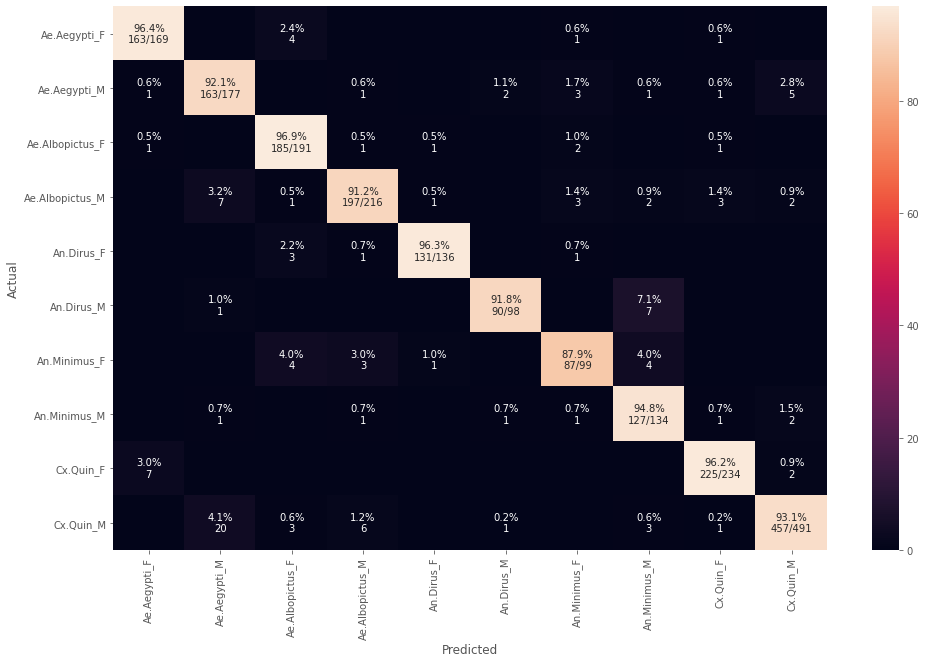

In [48]:
prediction = np.argmax(model.predict(X_test), axis = 1)
cm_analysis(np.argmax(y_test, axis = 1), prediction, filename='confusion_matrix_big_drop50%_lastest', labels=label_dict)

In [44]:
model.save('SmallCylinder/model/shift/model.h5')